In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import datetime
# xlrd is required for reading xls Excel files
import xlrd
import re
import sqlite3
import meteostat as mt
# Use this when displaying markdown in Jupyter Notebooks ( Gemini suggestion )
from IPython.display import display, Markdown
# do random forest regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [38]:
hourly_nighlty_threshold = 10

# Random Forest Regresion Analysis Of Solar and Weather



In [39]:
file_enriched_features = "data/processed_data/hourly_solar_copernicus_enriched_data.feather"
file_weather_data = "data/processed_data/hourly_weather_data.feather"
file_solar_data="data/processed_data/daily_solar_data.feather"


In [40]:
df_enriched_features=pd.read_feather(file_enriched_features)
df_weather_data = pd.read_feather(file_weather_data)
df_solar_data = pd.read_feather(file_solar_data)

In [41]:
df_solar_per_hour = df_solar_data[['PV(W)','DateTime']].resample('h', on='DateTime').sum()
# 
df_solar_data[df_solar_data['DateTime'].dt.date == datetime.date(2024,12,20)]

,Date,Number,Time,Working State,PV(W),Battery(W),Grid(W),Load(W),SOC(%),Total_Yield(kWh),Source_File,DateTime
28329,2024-12-20,1,00:00:00,Online,1.0,-31.44,-357.0,389.44,19.0,4.2,Daily+Power+Station+Chart_19-11-2025 - 2025-11...,2024-12-20 00:00:00
28330,2024-12-20,2,00:05:00,Online,1.0,-31.38,-278.0,310.38,19.0,4.2,Daily+Power+Station+Chart_19-11-2025 - 2025-11...,2024-12-20 00:05:00
28331,2024-12-20,3,00:10:00,Online,1.0,-31.38,-408.0,440.38,19.0,4.2,Daily+Power+Station+Chart_19-11-2025 - 2025-11...,2024-12-20 00:10:00
28332,2024-12-20,4,00:15:00,Online,1.0,-31.44,-165.0,197.44,19.0,4.2,Daily+Power+Station+Chart_19-11-2025 - 2025-11...,2024-12-20 00:15:00
28333,2024-12-20,5,00:20:00,Online,1.0,-31.44,-237.0,269.44,19.0,4.2,Daily+Power+Station+Chart_19-11-2025 - 2025-11...,2024-12-20 00:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...
28611,2024-12-20,283,23:35:00,Online,1.0,-31.26,-216.0,248.26,16.0,4.2,Daily+Power+Station+Chart_19-11-2025 - 2025-11...,2024-12-20 23:35:00
28612,2024-12-20,284,23:40:00,Online,1.0,-31.26,-133.0,165.26,16.0,4.2,Daily+Power+Station+Chart_19-11-2025 - 2025-11...,2024-12-20 23:40:00
28613,2024-12-20,285,23:45:00,Online,1.0,-31.26,-133.0,165.26,16.0,4.2,Daily+Power+Station+Chart_19-11-2025 - 2025-11...,2024-12-20 23:45:00
28614,2024-12-20,286,23:50:00,Online,1.0,-31.26,-130.0,162.26,16.0,4.2,Daily+Power+Station+Chart_19-11-2025 - 2025-11...,2024-12-20 23:50:00


In [42]:
# Show the columns/features for each dataset using pandas
sns.set_theme()
feature_columns = {
    "Enriched Features": df_enriched_features.columns,
    "Weather Data": df_weather_data.columns,
    "Solar Data": df_solar_data.columns,
}
for title, cols in feature_columns.items():
    display(pd.DataFrame({title: cols}))


,Enriched Features
0,DateTime
1,# Observation period
2,TOA
3,Clear sky GHI
4,Clear sky BHI
5,Clear sky DHI
6,Clear sky BNI
7,GHI
8,BHI
9,DHI


,Weather Data
0,DateTime
1,Temperature(C)
2,Humidity(%)
3,Solar Radiation(W/m^2)
4,Condition Code


,Solar Data
0,Date
1,Number
2,Time
3,Working State
4,PV(W)
5,Battery(W)
6,Grid(W)
7,Load(W)
8,SOC(%)
9,Total_Yield(kWh)


Convert to hourly date time granularity

This is too see if I can get more accurate readings

In [43]:
# change all the 3  to an hourly aggregation using resample
print(df_enriched_features.columns.to_list())
df_solar_per_hour = df_solar_data[['PV(W)','DateTime']].resample('h', on='DateTime').agg('mean')
df_weather_per_hour = df_weather_data.resample('h', on='DateTime').agg({'Temperature(C)': 'mean',
                                                                     'Humidity(%)': 'mean',
                                                                     'Solar Radiation(W/m^2)': 'mean',
                                                                     'Condition Code': 'first',})
# 'DateTime', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)'
df_enriched_per_hour = df_enriched_features.resample('h', on='DateTime').agg({
    'TOA': 'mean',
    'Clear sky GHI': 'mean',
    'Clear sky BHI': 'mean',
    'Clear sky DHI': 'mean',
    'GHI': 'mean',
    'BHI': 'mean',
    'DHI': 'mean',
    'BNI': 'mean',
    'POA_Pane_I(W/m^2)': 'mean',
    'POA_Pane_II(W/m^2)': 'mean',
    'POAC_Pane_I(W/m^2)': 'mean',
    'POAC_Pane_II(W/m^2)': 'mean',
    'Power_Pane_I(W)': 'mean',
    'Power_Pane_II(W)': 'mean',
    'Power_ClearSky_Pane_I(W)': 'mean',
    'Power_ClearSky_Pane_II(W)': 'mean',
    'Total_Power_Output(W)': 'mean',
    'Total_Power_ClearSky_Output(W)': 'mean'
})

['DateTime', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)']


In [44]:
df_merge_hourly = df_solar_per_hour.merge(df_weather_per_hour, on='DateTime').merge(df_enriched_per_hour, on='DateTime')
df_merge_hourly.reset_index(inplace=True)
# Add WeekOfYear
df_merge_hourly['WeekOfYear'] = df_merge_hourly['DateTime'].dt.isocalendar().week
df_merge_hourly['Month_Sin'] = np.sin(2 * np.pi * (df_merge_hourly['DateTime'].dt.month - 1) / 12)
df_merge_hourly['DayOfYear_Sin'] = np.sin(2 * np.pi * (df_merge_hourly['DateTime'].dt.dayofyear - 1) / 365)
df_merge_hourly['HourOfDay_Sin'] = np.sin(2 * np.pi * (df_merge_hourly['DateTime'].dt.hour) / 24)
# Count number Nan in target Y column
print("Number of NaN in PV(W):", df_merge_hourly['PV(W)'].isna().sum())
# Remove Nan in target Y column
df_merge_hourly = df_merge_hourly.dropna(subset=['PV(W)'])
# Count number of rows after removing NaN
print("Number of NaN  after removing in PV(W):", df_merge_hourly['PV(W)'].isna().sum())
print("Number of rows after removing NaN in PV(W):", len(df_merge_hourly))
print("Dataframe shape after removing NaN in PV(W):", df_merge_hourly.shape)

Number of NaN in PV(W): 413
Number of NaN  after removing in PV(W): 0
Number of rows after removing NaN in PV(W): 9976
Dataframe shape after removing NaN in PV(W): (9976, 28)


In [45]:
# display column list and data types and index
display(pd.DataFrame({"Columns": df_merge_hourly.columns, "Data Types": df_merge_hourly.dtypes}))


,Columns,Data Types
DateTime,DateTime,datetime64[ns]
PV(W),PV(W),float64
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
Solar Radiation(W/m^2),Solar Radiation(W/m^2),Float64
Condition Code,Condition Code,Float64
TOA,TOA,float64
Clear sky GHI,Clear sky GHI,float64
Clear sky BHI,Clear sky BHI,float64
Clear sky DHI,Clear sky DHI,float64


## Plot the solar output to determine cutoff points

The objective is to visually examine the output and determine the threshold for night time. It is more accurrate to have a rule that determines that there is no power , and not train the model on this. it skews the accuracy. This was from a gemini prompt to assist in building the model. The Clear SKY GDI shows the output based on clear sky , even at night because of abient light from street lights , and full moon there is still power generation at night. This system can generate up to 300 W on a very bright full moon.

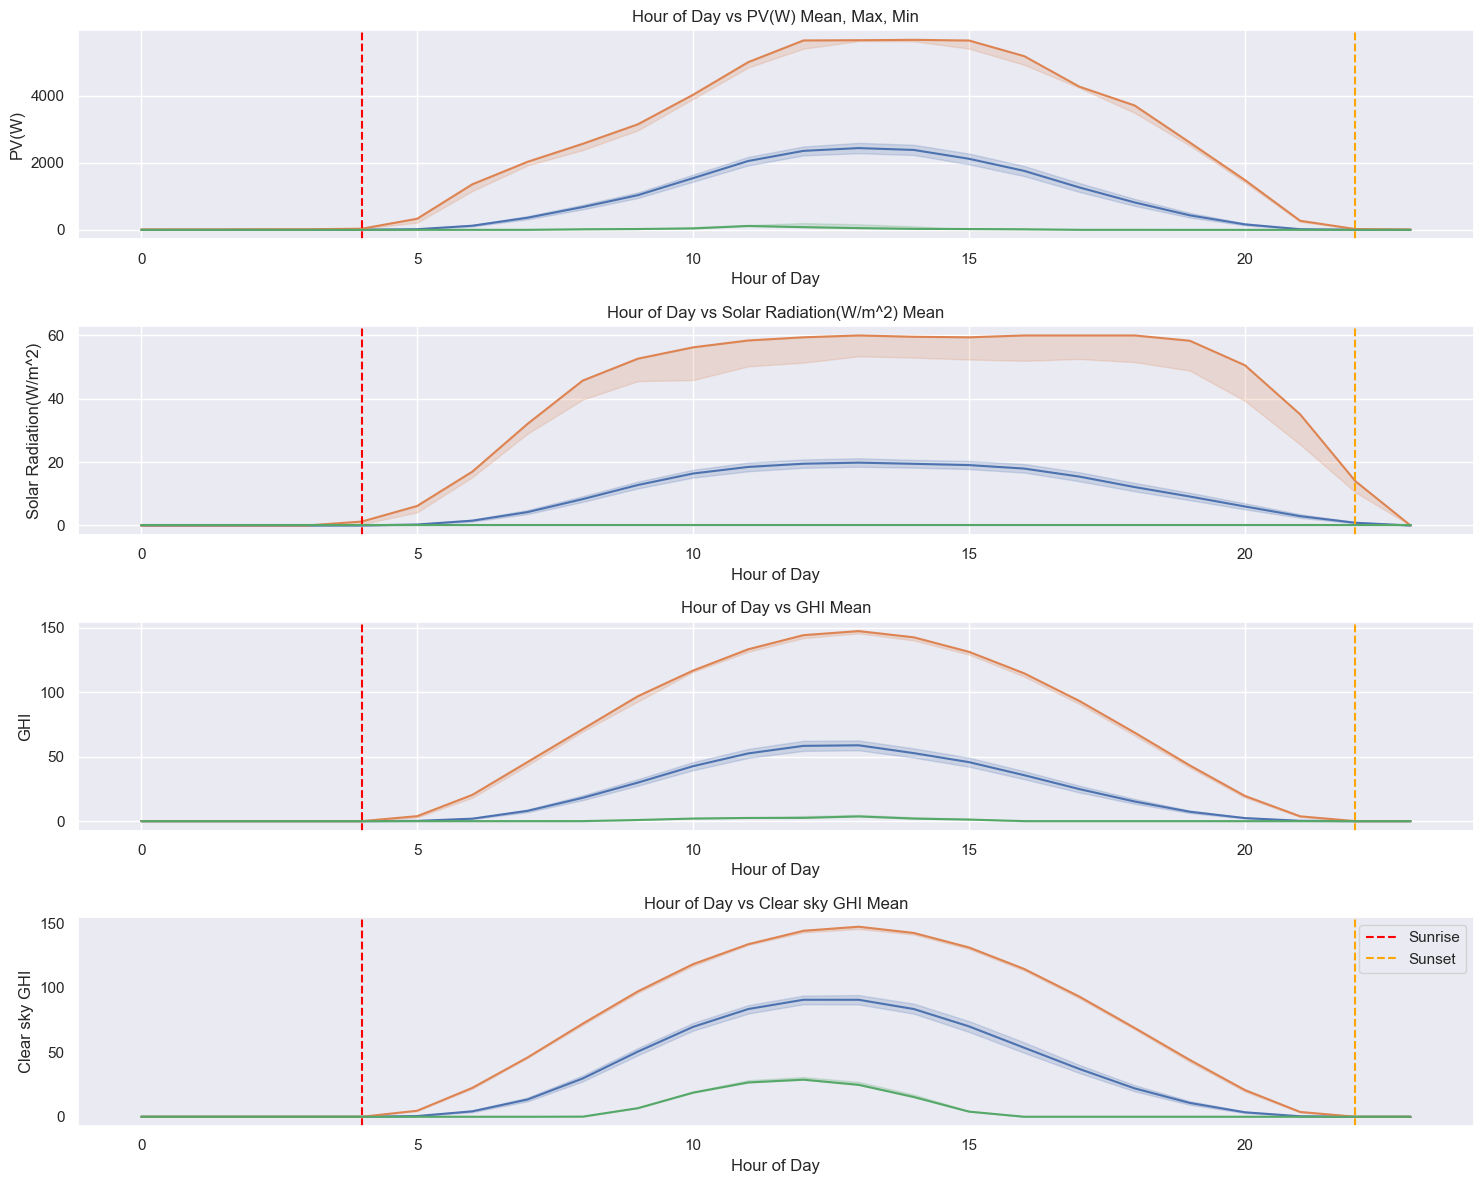

In [46]:
# plot the hour of day vs max , min , mean of PV(W)
fig, ax = plt.subplots(4,1 , figsize=(15 , 12) )
# flatten ax
ax = ax.flatten()
plt.grid()
# plot hour of day vs min, max , mean of PV(W)
sns.lineplot(data=df_merge_hourly, x=df_merge_hourly['DateTime'].dt.hour, y='PV(W)', estimator='mean', ax=ax[0])
sns.lineplot(data=df_merge_hourly, x=df_merge_hourly['DateTime'].dt.hour, y='PV(W)', estimator='max', ax=ax[0])
sns.lineplot(data=df_merge_hourly, x=df_merge_hourly['DateTime'].dt.hour, y='PV(W)', estimator='min', ax=ax[0])
# plot the mean line below hourly_nighlty_threshold with dashed line
#sns.lineplot(data=df_merge_hourly[df_merge_hourly['PV(W)'] < hourly_nighlty_threshold], x=df_merge_hourly['DateTime'].dt.hour, y='PV(W)', estimator='mean', ax=ax[0], linestyle='--')
# draw a red vertical line at sunrise and sunset hours (4 and 22)
ax[0].axvline(x=4, color='red', linestyle='--', label='Sunrise')
ax[0].axvline(x=22, color='orange', linestyle='--', label='Sunset')
ax[0].set_title('Hour of Day vs PV(W) Mean, Max, Min')
ax[0].set_xlabel('Hour of Day')
# Same plot for Solar Radiation
ax[1].set_title('Hour of Day vs Solar Radiation(W/m^2) Mean')
ax[1].set_xlabel('Hour of Day')
sns.lineplot(data=df_merge_hourly, x=df_merge_hourly['DateTime'].dt.hour, y='Solar Radiation(W/m^2)', estimator='mean', ax=ax[1])
sns.lineplot(data=df_merge_hourly, x=df_merge_hourly['DateTime'].dt.hour, y='Solar Radiation(W/m^2)', estimator='max', ax=ax[1])
sns.lineplot(data=df_merge_hourly, x=df_merge_hourly['DateTime'].dt.hour, y='Solar Radiation(W/m^2)', estimator='min', ax=ax[1])
# draw a red vertical line at sunrise and sunset hours (4 and 22)
ax[1].axvline(x=4, color='red', linestyle='--', label='Sunrise')
ax[1].axvline(x=22, color='orange', linestyle='--', label='Sunset')
ax[2].set_title('Hour of Day vs GHI Mean')
ax[2].set_xlabel('Hour of Day')
sns.lineplot(data=df_merge_hourly, x=df_merge_hourly['DateTime'].dt.hour, y='GHI', estimator='mean', ax=ax[2])
sns.lineplot(data=df_merge_hourly, x=df_merge_hourly['DateTime'].dt.hour, y='GHI', estimator='max', ax=ax[2])
sns.lineplot(data=df_merge_hourly, x=df_merge_hourly['DateTime'].dt.hour, y='GHI', estimator='min', ax=ax[2])
# draw a red vertical line at sunrise and sunset hours (4 and 22)
ax[2].axvline(x=4, color='red', linestyle='--', label='Sunrise')
ax[2].axvline(x=22, color='orange', linestyle='--', label='Sunset')
ax[3].set_title('Hour of Day vs Clear sky GHI Mean')
ax[3].set_xlabel('Hour of Day')
sns.lineplot(data=df_merge_hourly, x=df_merge_hourly['DateTime'].dt.hour, y='Clear sky GHI', estimator='mean', ax=ax[3])
sns.lineplot(data=df_merge_hourly, x=df_merge_hourly['DateTime'].dt.hour, y='Clear sky GHI', estimator='max', ax=ax[3])
sns.lineplot(data=df_merge_hourly, x=df_merge_hourly['DateTime'].dt.hour, y='Clear sky GHI', estimator='min', ax=ax[3])
# draw a red vertical line at sunrise and sunset hours (4 and 22)
ax[3].axvline(x=4, color='red', linestyle='--', label='Sunrise')
ax[3].axvline(x=22, color='orange', linestyle='--', label='Sunset')
plt.tight_layout()
plt.legend()
plt.show()# save the merged dataframe


Look at only hours between 4 and 22 

## Histogram of various solar measures 

This shows a histogram of the various measures solar output. 

In [49]:
print("Columns:", df_merge_hourly.columns.tolist())
feature_cols = ['Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 'Condition Code', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'GHI',
                'Total_Power_Output(W)', 'Power_Pane_I(W)', 'Power_Pane_II(W)','Clear sky GHI',
                'Total_Power_ClearSky_Output(W)','Power_ClearSky_Pane_I(W)','Power_ClearSky_Pane_II(W)']
target_col = 'PV(W)'

Columns: ['DateTime', 'PV(W)', 'Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 'Condition Code', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'GHI', 'BHI', 'DHI', 'BNI', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)', 'WeekOfYear', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']


In [54]:
print("Columns:", df_merge_hourly.columns.tolist())#
#feature_cols = ['Temperature(C)', 'Humidity(%)', 'Condition Code', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin',
#                'Total_Power_ClearSky_Output(W)','Power_ClearSky_Pane_I(W)','Power_ClearSky_Pane_II(W)']
feature_cols = ['Temperature(C)', 'Humidity(%)', 'Condition Code', 'Month_Sin',  'HourOfDay_Sin', 
                'Total_Power_ClearSky_Output(W)']
target_col = 'PV(W)'
print(f"\nTesting Random Forest Regressor with target: {target_col} and features: {feature_cols}")
# first we filter  out where the output is less than threshold - to avoid night time data , this is based on clearsky GHI
df_daytime = df_merge_hourly['Clear sky GHI'] > 10
# now split into test and training based test and train data sets are every other week
df_daytime_train = df_merge_hourly[(df_merge_hourly['WeekOfYear'] % 2 == 0) & (df_daytime)]
df_daytime_test = df_merge_hourly[(df_merge_hourly['WeekOfYear'] % 2 == 1) & (df_daytime)]
print("Training DataFrame shape:", df_daytime_train.shape)
print("Testing DataFrame shape:", df_daytime_test.shape)
# Create x and y for training and testing
X_train = df_daytime_train[feature_cols]
y_train = df_daytime_train[target_col]
X_test = df_daytime_test[feature_cols]
y_test = df_daytime_test[target_col]


Columns: ['DateTime', 'PV(W)', 'Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 'Condition Code', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'GHI', 'BHI', 'DHI', 'BNI', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)', 'WeekOfYear', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']

Testing Random Forest Regressor with target: PV(W) and features: ['Temperature(C)', 'Humidity(%)', 'Condition Code', 'Month_Sin', 'HourOfDay_Sin', 'Total_Power_ClearSky_Output(W)']
Training DataFrame shape: (2176, 28)
Testing DataFrame shape: (2187, 28)


In [55]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42,max_depth=16,min_samples_split=5,min_samples_leaf=2)
# Train the model
print("Fitting model...")
rf_model.fit(X_train, y_train)
# Make predictions
print("Making predictions on test set...")
y_pred = rf_model.predict(X_test)
print("Making predictions on test set... Done")
# making predictions on training set
y_train_pred = rf_model.predict(X_train)

      

Fitting model...
Making predictions on test set...
Making predictions on test set... Done


__Metrics for Tests 


Training Metrics:
RMSE: 323.84, MAE: 226.14, R2: 0.9484, N-RMSE: 0.0386, N-MAE: 0.0269

Testing Metrics:
RMSE: 686.18, MAE: 494.37, R2: 0.7556, N-RMSE: 0.0817, N-MAE: 0.0589


<Axes: xlabel='Importance', ylabel='Feature'>

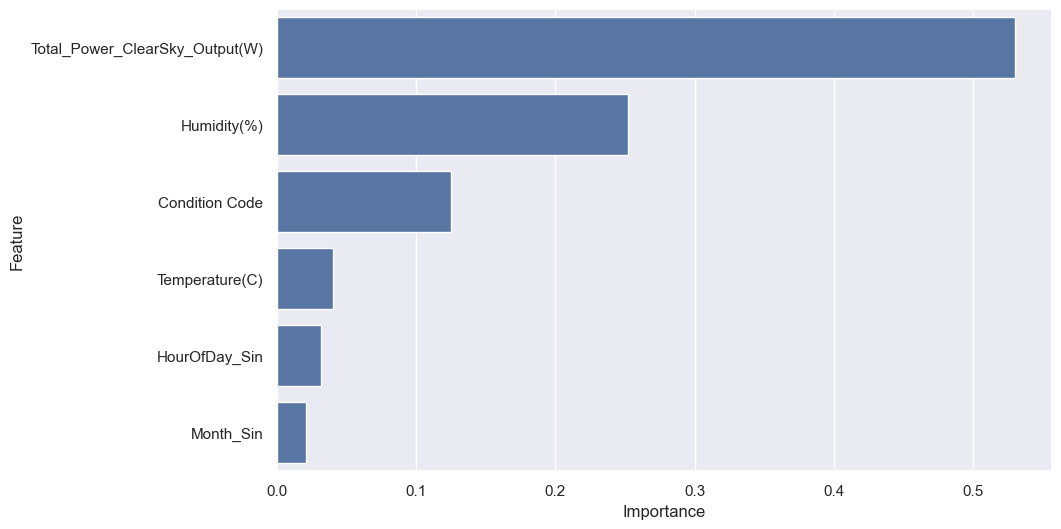

In [56]:
# generate 3 main metrics: RMSE, MAE, R2 for both training and testing
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = r2_score(y_true, y_pred)
    # and normalized based on MAX of y_true - the standard practice for solar prediction
    #normalization_factor = np.max(y_true) 
    normalization_factor = 8400 # based on max PV(W) based on system size
    n_rmse = rmse / normalization_factor
    n_mae = mae / normalization_factor
    
    return rmse, mae, r2 , n_rmse, n_mae
train_rmse, train_mae, train_r2, train_n_rmse, train_n_mae = calculate_metrics(y_train, y_train_pred)
test_rmse, test_mae, test_r2, test_n_rmse, test_n_mae = calculate_metrics(y_test, y_pred)
# print the metrics
print(f"\nTraining Metrics:\nRMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, R2: {train_r2:.4f}, N-RMSE: {train_n_rmse:.4f}, N-MAE: {train_n_mae:.4f}")
print(f"\nTesting Metrics:\nRMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, R2: {test_r2:.4f}, N-RMSE: {test_n_rmse:.4f}, N-MAE: {test_n_mae:.4f}")
# feature importance plot
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)

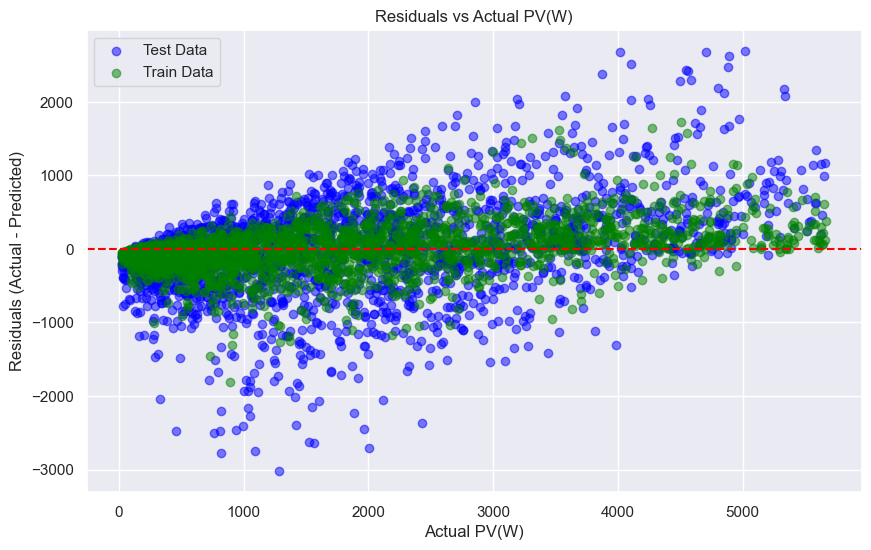

In [59]:
# plot residuals
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_test - y_pred, color='blue', label='Test Data', alpha=0.5)
plt.scatter(y_train, y_train - y_train_pred, color='green', label='Train Data', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Actual PV(W)')
plt.xlabel('Actual PV(W)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()


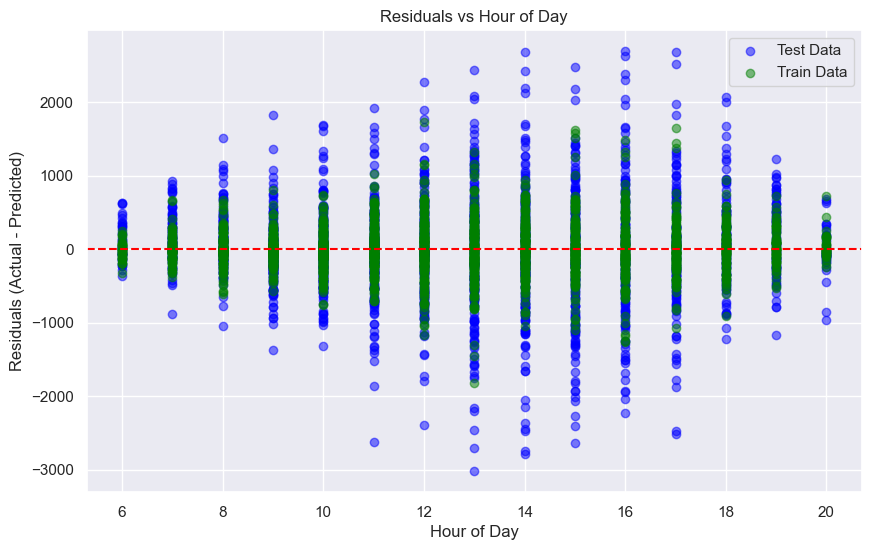

In [60]:
# plot risduals per hour of day
plt.figure(figsize=(10,6))
plt.scatter(df_daytime_test['DateTime'].dt.hour, y_test - y_pred, color='blue', label='Test Data', alpha=0.5)
plt.scatter(df_daytime_train['DateTime'].dt.hour, y_train - y_train_pred
, color='green', label='Train Data', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

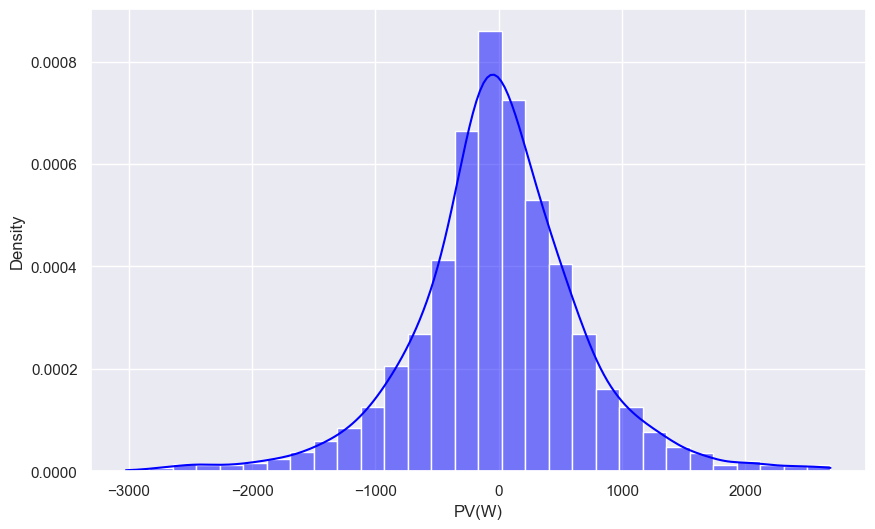

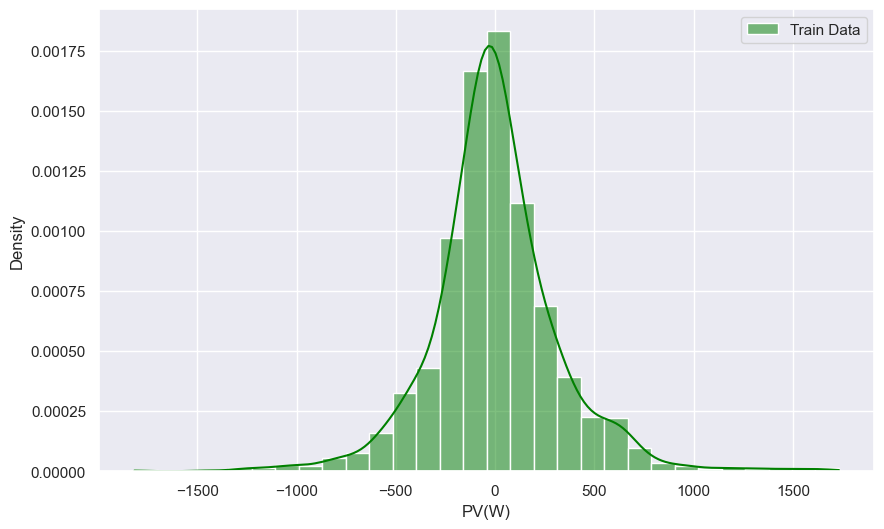

In [67]:
# Residual histogram
plt.figure(figsize=(10,6))
sns.histplot(y_test - y_pred, color='blue', label='Test Data', kde=True, stat="density", bins=30)
plt.figure(figsize=(10,6))
sns.histplot(y_train - y_train_pred, color='green', label='Train Data', kde=True, stat="density", bins=30)
plt.legend()
plt.show()

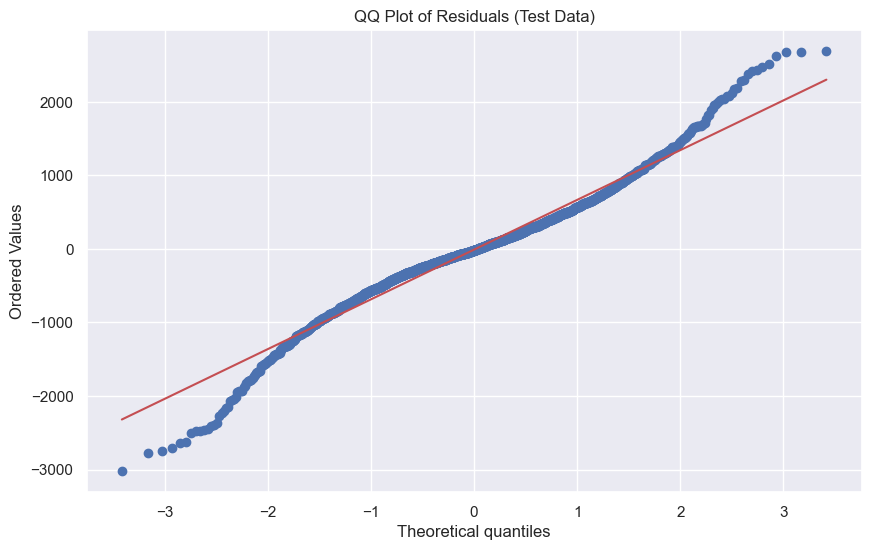

In [68]:
# Add QQ plot for residuals
import scipy.stats as stats
plt.figure(figsize=(10,6))
stats.probplot(y_test - y_pred, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals (Test Data)')
plt.show()


In [63]:
from xml.parsers.expat import errors
import scipy.stats as stats
# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint 
rf_model = RandomForestRegressor(n_estimators=100, random_state=42,max_depth=16,min_samples_split=5,min_samples_leaf=2)
# Train the model
print("Fitting model...")
rf_model.fit(X_train, y_train)
# Make predictions
print("Making predictions on test set...")
y_pred = rf_model.predict(X_test)
print("Making predictions on test set... Done")
# making predictions on training set
y_train_pred = rf_model.predict(X_train)


# Make predictions
print("Making predictions on test set...")
y_pred = rf_model.predict(X_test)
param_dist = {
  'n_estimators': randint(100, 500),
  'max_depth': randint(3, 15),
  'min_samples_split': randint(2, 10),
  'min_samples_leaf': randint(1, 5)
}
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist,
                                      n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
rf_random_search.fit(X_train, y_train)
print("Best parameters found: ", rf_random_search.best_params_)
# Evaluate the mod
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Fitting model...
Making predictions on test set...
Making predictions on test set... Done
Making predictions on test set...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 230}
Mean Squared Error: 470841.9021460479
R^2 Score: 0.7556307671895561



Training Metrics:
RMSE: 323.84, MAE: 226.14, R2: 0.9484, N-RMSE: 0.0386, N-MAE: 0.0269

Testing Metrics:
RMSE: 686.18, MAE: 494.37, R2: 0.7556, N-RMSE: 0.0817, N-MAE: 0.0589


<Axes: xlabel='Importance', ylabel='Feature'>

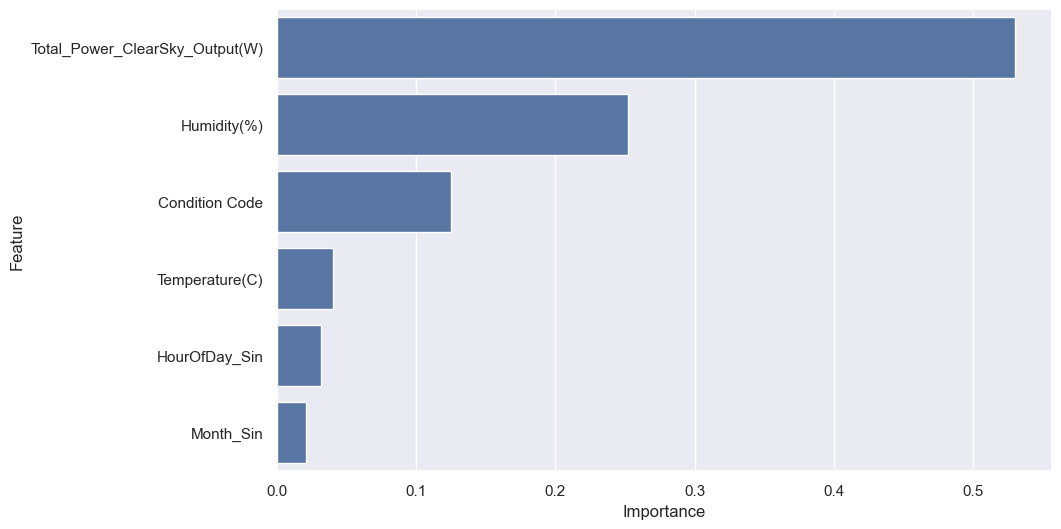

In [64]:
# generate 3 main metrics: RMSE, MAE, R2 for both training and testing
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = r2_score(y_true, y_pred)
    # and normalized based on MAX of y_true - the standard practice for solar prediction
    #normalization_factor = np.max(y_true) 
    normalization_factor = 8400 # based on max PV(W) based on system size
    n_rmse = rmse / normalization_factor
    n_mae = mae / normalization_factor
    
    return rmse, mae, r2 , n_rmse, n_mae
train_rmse, train_mae, train_r2, train_n_rmse, train_n_mae = calculate_metrics(y_train, y_train_pred)
test_rmse, test_mae, test_r2, test_n_rmse, test_n_mae = calculate_metrics(y_test, y_pred)
# print the metrics
print(f"\nTraining Metrics:\nRMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, R2: {train_r2:.4f}, N-RMSE: {train_n_rmse:.4f}, N-MAE: {train_n_mae:.4f}")
print(f"\nTesting Metrics:\nRMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, R2: {test_r2:.4f}, N-RMSE: {test_n_rmse:.4f}, N-MAE: {test_n_mae:.4f}")
# feature importance plot
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)

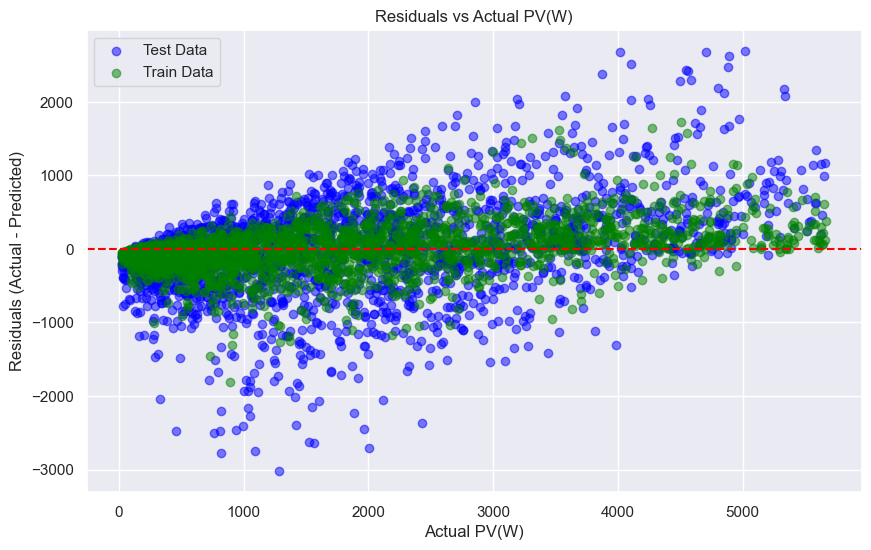

In [65]:
# plot residuals
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_test - y_pred, color='blue', label='Test Data', alpha=0.5)
plt.scatter(y_train, y_train - y_train_pred, color='green', label='Train Data', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Actual PV(W)')
plt.xlabel('Actual PV(W)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()


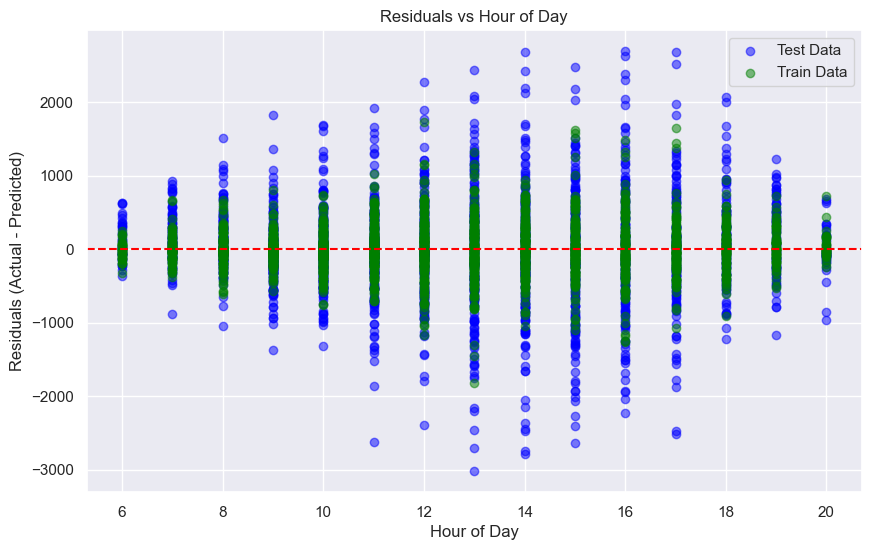

In [66]:
# plot risduals per hour of day
plt.figure(figsize=(10,6))
plt.scatter(df_daytime_test['DateTime'].dt.hour, y_test - y_pred, color='blue', label='Test Data', alpha=0.5)
plt.scatter(df_daytime_train['DateTime'].dt.hour, y_train - y_train_pred
, color='green', label='Train Data', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()